<img style="float: right;" src="http://static.ucalgary.ca/2013-001/980/global/images/identity/vertical-crest.png"/>
<BR><BR><BR>
    
# Introduction to Apache Spark
### Instructor: Dave Schulz (Research Computing Services)

An introduction to basic theory of Map-Reduce applied to Resilient Distributed Datasets (RDD). This course primarily uses PySpark to introduce the Spark approach to parallelization.

This course will begin with an introduction to RDDs and MapReduce. We will demonstrate how to load data to an RDD and how to make use of the RDD API. This introduction will include practical examples of filtering, transforming, and aggregating a data stream with the RDD API. We will also introduce additional high level Spark APIs such as the DataFrame API.

Target audience: researchers interested in a first introduction to parallel computations in a Spark framework

Duration: 3 hours

Level: beginner

Prerequisites: This course assumes a familiarity with basic python syntax for variable declaration, function definition and use, and iteration.


Laptop software: All attendees will need to bring their laptops with wireless access and with a remote SSH client installed (on Windows laptops we recommend the free edition of MobaXterm; on Mac and Linux laptops no need to install anything).

# Preamble

## Load Notebook

* Login to Arc with your ssh client and copy the notebook file into your homedirectory
````shell
 ssh arc.ucalgary.ca -l <your username>
 cp /global/software/spark/SummerSchool/IntroToSpark2019.ipynb ~
````
* Point your browser at jupyter.ucalgary.ca and sign in with your UC account.
* Open a copy of this notebook file from IntroToSpark2019.ipynb.

## Initialize Spark 
* We'll do that early so that the helpers have time to troubleshoot while we get things started.
* The following cell should end in something like the following (the batch job number will be different):
> INFO:sparkhpc.sparkjob:Submitted batch job 802388
>
> INFO:sparkhpc.sparkjob:Submitted cluster 0
* This code is on our website https://hpc.ucalgary.ca/arc/software/spark

* Firstly check that you don't already have a spark cluster running.  The following should not have a line that mentions spark in the NAME column

In [1]:
!squeue -u $USER


             JOBID       PARTITION     NAME            USER    STATE       TIME TIME_LIMIT  TIME_LEFT START_TIME NODES CPUS NODELIST(REASON)    
            879035          single jupyterh         dschulz  RUNNING       0:49    6:00:00    5:59:11 2019-05-27     1    1 cn002               


In [2]:
import os
import atexit
import sys

import pyspark
from pyspark.context import SparkContext
from pyspark.sql import SQLContext
import findspark
from sparkhpc import sparkjob

#Exit handler to clean up the Spark cluster if the script exits or crashes
def exitHandler(sj,sc):
    try:
        print('Trapped Exit cleaning up Spark Context')
        sc.stop()
    except:
        pass
    try:
        print('Trapped Exit cleaning up Spark Job')
        sj.stop()
    except:
        pass

findspark.init()

#Parameters for the Spark cluster
nodes=3
tasks_per_node=8
memory_per_task=1024 #1 gig per process, adjust accordingly
# Please estimate walltime carefully to keep unused Spark clusters from sitting 
# idle so that others may use the resources.
walltime="3:00" #3 hours
os.environ['SBATCH_PARTITION']='lattice' #Set the appropriate ARC partition

sj = sparkjob.sparkjob(
     ncores=nodes*tasks_per_node,
     cores_per_executor=tasks_per_node,
     memory_per_core=memory_per_task,
     walltime=walltime
    )

sj.wait_to_start()
sc = sj.start_spark()

#Register the exit handler                                                                                                     
atexit.register(exitHandler,sj,sc)

#You need this line if you want to use SparkSQL
sqlCtx=SQLContext(sc)

INFO:sparkhpc.sparkjob:Submitted batch job 879036

INFO:sparkhpc.sparkjob:Submitted cluster 0


In [3]:
#things we'll need later
import matplotlib.pyplot as plt
import re
import operator
%matplotlib notebook 
import random


# Our Spark Journey
* MySQL ~ weeks
 * Single server with a handful of raid disks
* BigByte ~ day
 * 1TB ram -- put the source all in ramdisk
* Woozle ~ 10 min
 * Very old cluster of 32 nodes 4 cores per node
 * Originally Installed in 2008
 * Work done circa 2013
* Catalyst ~ 10 min -> <1 min with spark
 * Current system.
 * 20 nodes
 * HDFS
 * Hadoop & Spark both installed



# What is Big Data
* Intractable on a single machine
* Because of:
 * disk
 * ram
 * computation time (cpu)
* A dataset that requires parallelization to process in a reasonable amount of time.

<img style="float: right;" src="https://cdn-images-1.medium.com/max/1200/1*yWFQiGjlgHUVYeh4ELELyw.jpeg" width=30% />

# Data Cleaning
* Missing data
* Entity resolution
* Unit Mismatches
* Date formats
* nonsense values

<img style="float: right;" src="https://spark.apache.org/images/spark-logo-trademark.png" width=20% />


# Why Apache Spark instead of Hadoop Map Reduce?
* Short iteration cycle
* Caching -- keep intermediate results in ram instead of writing/reading from disk
 * Can use disk if out of ram
 * The programmer can coach Spark about what needs to stay in ram
* You can keep the data pipeline spooled up
* Create RDD, then try things against it
* Handles node failures gracefully 
* In Spark we setup plumbing then open the valve into the established plumbing.  
 * Since we describe what to do instead of actually doing it, we can repeat a failed task as it is just re-executing the same plumbing.



# A Word on Filesystems
* What is HDFS (Hadoop Distributed FileSystem)
* Why do we use NFS instead of HDFS?

<img style="float: right;" src="http://4.bp.blogspot.com/_j6mB7TMmJJY/SS0BMwJtUsI/AAAAAAAAAF4/w2YM5b1lff4/s400/P1.png" />

# What is Map-Reduce?
* Think grep + sort + uniq

## Example
In the following text block, what is the count of words in the lines containing the word "the"

### Input Text filename: input.txt

  the quick brown fox
  
  jumped over
  
  the lazy dog. the quick
  
  brown fox jumped over
  
  the lazy dog

### Answer the unix way:
#### The Map
1. grep lines containing "the"
2. delete the period character
2. change spaces to line breaks
3. sort the list of words

#### The Reduce
4. uniq-count the list

#### All together
````bash
$cat ~/input.txt | grep the | tr -d '.' | tr " " "\n" | sort | uniq -c
````
````
     1 brown
     2 dog
     1 fox
     2 lazy
     2 quick
     4 the
````
## The Problem
* Not parallelized

## The Parallel solution the hard way
1. Split the file into 2 files (around half the lines in each but it doesn't matter that much)
1. Perform the Map and Reduce part on each file in different processes at the same time
1. Left with two results:
 * File #1:
````
     1 brown
     1 dog
     1 fox
     1 lazy
     2 quick
     3 the
````
 * File #2:
````
     1 dog
     1 lazy
     1 the
````
1. Reduce them.... merge by key in column #2 (the words)
* We avoided the ***expensive*** sort over the whole list (sorted in each separate process)

## The Problem
* Not that time consuming to setup for 2 processes but very much so with 1000's

# Spark Data Structures
## RDD
* Main Data structure in Spark
* Collection of objects distributed throughout a cluster
* Calling methods on the RDD object that are "Transformations" set up "the plumbing"
* After Transformations are called, then "Actions" cause the data to flow.

## DataFrames (Spark Dataframe -- not Pandas Dataframe)
* Similar to a Pandas dataframe but parallelized across the cluster
* Can be thought of like a table in a database
* THE COOL PART: Can write fast SparkSQL queries against the Spark Dataframes as if they are tables in a database -- with some limitations.

---
# The Hands on Part

* We're going to count the words in an academic paper which is an ancestor of Spark.
* Small example that will NOT illustrate scaling

## Confirm Spark is Ready

In [4]:
print(sc.version)
assert(sc.version=='2.4.0')

2.4.0


## Load some Data
* Let's take a historical Hadoop paper. This paper is rumoured to be what started hadoop. https://ai.google/research/pubs/pub62.pdf

* The paper has been converted from pdf to text and left in /global/software/spark/SummerSchool/pub62.txt
* The following cell creates an RDD from the lines of the pub62.txt file.
* The take() function is an action which realizes the "plumbing" which was setup.
* The sc.textFile function does very little and doesn't even load the file.  It just connects the RDD's input to that file waiting for an action to tell it to start reading.
* The take() function is the action that tells Spark to read from it's input until 10 lines/items are produced at the output. -- Similar to the Unix tail program or a LIMIT clause in a SQL database.

In [5]:
hadoopPaperRDD=sc.textFile('/global/software/spark/SummerSchool/pub62.txt')
print("Number of Lines in RDD:%i" % hadoopPaperRDD.count())
print("First few lines:")
hadoopPaperRDD.take(10)


Number of Lines in RDD:1296
First few lines:


['MapReduce: Simplified Data Processing on Large Clusters',
 'Jeffrey Dean and Sanjay Ghemawat',
 'jeff@google.com, sanjay@google.com',
 '',
 'Google, Inc.',
 '',
 'Abstract',
 'MapReduce is a programming model and an associated implementation for processing and generating large',
 'data sets. Users specify a map function that processes a',
 'key/value pair to generate a set of intermediate key/value']

# Clean the Data
* Not a complete cleaning - simplified for illustration purposes
* For the first part, we'll use a standard function, and for the second part we'll use a lambda function
 * Delete all non alphabet or space characters
 * Lowercase all characters
 * split on spaces
 * Should have rows with a list of all words in each line -- will have repeats
* We'll do the above with a map function.  
* First we write the function and test it, then Spark will take care of copying the function to the other nodes.  
* We can run the function here in the notebook as it is an ordinary function.
## Things We'll Need
* re.sub -- Regular Expression Substitute https://docs.python.org/2/library/re.html#re.sub
* lower() -- Return the lowercase version of a string https://docs.python.org/3/library/stdtypes.html#str.lower


In [6]:

def cleanRow(row):
    
    # Delete all non alphanumeric characters
    rowAlnum=re.sub('[^a-zA-Z0-9 ]+','', row)
    
    # Lowercase the entire string
    rowLowercase=rowAlnum.lower()
    
    return rowLowercase



## Test the Above Function

testRow=hadoopPaperRDD.take(1)
print("Before: %s" % testRow)
print(" After: %s" % cleanRow(str(hadoopPaperRDD.take(1))))
assert(cleanRow(str(hadoopPaperRDD.take(1))) == 'mapreduce simplified data processing on large clusters')

Before: ['MapReduce: Simplified Data Processing on Large Clusters']
 After: mapreduce simplified data processing on large clusters


# Apply the cleanRow() Function to the Rows of the RDD
## Things We'll Need
* map() - Map the values in the RDD https://spark.apache.org/docs/2.1.0/api/python/pyspark.html#pyspark.RDD.map
* take() - Return the first (x) values unordered https://spark.apache.org/docs/2.1.0/api/python/pyspark.html#pyspark.RDD.take

In [7]:
hadoopPaperRDD_lowercased=hadoopPaperRDD.map(cleanRow)
hadoopPaperRDD_lowercased.take(10)

['mapreduce simplified data processing on large clusters',
 'jeffrey dean and sanjay ghemawat',
 'jeffgooglecom sanjaygooglecom',
 '',
 'google inc',
 '',
 'abstract',
 'mapreduce is a programming model and an associated implementation for processing and generating large',
 'data sets users specify a map function that processes a',
 'keyvalue pair to generate a set of intermediate keyvalue']

## Now let's Split on Spaces
* We'll use a regex to split the rows on spaces and a new function called flatMap
### Things We'll Need
* flatMap() -- Map values but return separate list elements as separate records https://spark.apache.org/docs/2.1.0/api/python/pyspark.html#pyspark.RDD.flatMap
* take() - Return the first (x) values unordered https://spark.apache.org/docs/2.1.0/api/python/pyspark.html#pyspark.RDD.take

In [8]:
hadoopPaperRDD_split=hadoopPaperRDD_lowercased.flatMap(lambda x: re.split(' ', x))
hadoopPaperRDD_split.take(10)

['mapreduce',
 'simplified',
 'data',
 'processing',
 'on',
 'large',
 'clusters',
 'jeffrey',
 'dean',
 'and']

# Result: List of Words
* The result is a list of words in roughly the same order they were in the original file.
* Still need to count distinct words
* need a key-value pair list of the form word->count
* Something un-obvious to be done here, set each word->1 and combine in the reducer
## Things We'll Need
* map() - Map the values in the RDD https://spark.apache.org/docs/2.1.0/api/python/pyspark.html#pyspark.RDD.map
* take() - Return the first (x) values unordered https://spark.apache.org/docs/2.1.0/api/python/pyspark.html#pyspark.RDD.take

In [9]:
wordListUnmergedRDD=hadoopPaperRDD_split.map(lambda x: (x,1))
wordListUnmergedRDD.take(10)

[('mapreduce', 1),
 ('simplified', 1),
 ('data', 1),
 ('processing', 1),
 ('on', 1),
 ('large', 1),
 ('clusters', 1),
 ('jeffrey', 1),
 ('dean', 1),
 ('and', 1)]

# Merge the Keys
* we have something like this:
 * keyA=1
 * keyA=1
 * keyB=1
 * keyC=1
 * keyA=1
* We want this:
 * keyA=3
 * keyB=1
 * keyC=1
* To do this we use the function reduceByKey()
## Things We'll Need
* reduceByKey() - Merge the values for each key using an associative, commutative function https://spark.apache.org/docs/2.1.0/api/python/pyspark.html#pyspark.RDD.reduceByKey
* count() - Count the number of values returned by the RDD https://spark.apache.org/docs/2.1.0/api/python/pyspark.html#pyspark.RDD.count
* take() - Return the first (x) values unordered https://spark.apache.org/docs/2.1.0/api/python/pyspark.html#pyspark.RDD.take

In [10]:

wordListMergedRDD=wordListUnmergedRDD.reduceByKey(operator.add)
print("Record count=%i"%wordListMergedRDD.count())
wordListMergedRDD.take(10)


Record count=1781


[('particular', 5),
 ('record', 4),
 ('skipped', 1),
 ('when', 25),
 ('issues', 3),
 ('reexecution', 6),
 ('of', 338),
 ('reduce', 91),
 ('task', 50),
 ('', 290)]

### WAIT! '' is NOT a word!  Let's remove it
* While we're at it, maybe we don't like works <= 2 characters
* Or words that start with a digit (probably numbers)
## Things We'll Need
* reduceByKey() - Merge the values for each key using an associative, commutative function https://spark.apache.org/docs/2.1.0/api/python/pyspark.html#pyspark.RDD.reduceByKey
* filter() - Return an RDD with elements that satisfy the condition https://spark.apache.org/docs/2.1.0/api/python/pyspark.html#pyspark.RDD.filter
* take() - Return the first (x) values unordered https://spark.apache.org/docs/2.1.0/api/python/pyspark.html#pyspark.RDD.take

In [11]:
wordListMergedRDD=(
    wordListUnmergedRDD
    .filter(lambda x: re.match('^\D', x[0])) #Remove starts with a digit
    .filter(lambda x: x[0]!='')              #Remove empty string
    .filter(lambda x: len(x[0]) > 2)         #Remove showrt words <=2 characters
    .reduceByKey(operator.add)               #Count all the words
)
print("Record count=%i"%wordListMergedRDD.count())
wordListMergedRDD.take(10)

Record count=1595


[('simplified', 1),
 ('large', 32),
 ('clusters', 5),
 ('jeffrey', 2),
 ('sanjay', 2),
 ('sanjaygooglecom', 1),
 ('google', 14),
 ('inc', 1),
 ('abstract', 1),
 ('programming', 14)]

# Let's sort this a couple of ways
## Things We'll Need
* sortByKey() - Sort the RDD by the Key https://spark.apache.org/docs/2.1.0/api/python/pyspark.html#pyspark.RDD.sortByKey
* sortBy() - Sort by something else based on a function written by you https://spark.apache.org/docs/2.1.0/api/python/pyspark.html#pyspark.RDD.sortBy

In [12]:
wordListMergedRDD.sortByKey().take(10)

[('able', 2),
 ('abort', 1),
 ('aborts', 1),
 ('about', 12),
 ('above', 4),
 ('abstract', 1),
 ('abstraction', 2),
 ('abstractions', 1),
 ('acceptable', 1),
 ('accepts', 2)]

In [13]:
wordListMergedRDD.sortBy(lambda x: x[1], ascending=False).take(10)

[('the', 611),
 ('and', 194),
 ('for', 112),
 ('mapreduce', 93),
 ('reduce', 91),
 ('data', 82),
 ('that', 80),
 ('map', 79),
 ('output', 67),
 ('tasks', 56)]

# Count Word First Letters
## We need a map function
* Let's use a real function instead of a lambda function for this
* Allows multi-line functions
* Can NOT share data between mappers

In [14]:
def getFirstLetter(kvp):
    a=kvp[0][0]
    b=kvp[1]
    return (a,b)
print(getFirstLetter(('abc', 100)))
assert (getFirstLetter(('abc', 100)) == ('a', 100))

('a', 100)


In [15]:
firstLetterFrequency=(
    wordListMergedRDD
    .filter(lambda x: len(x[0])>0)
    .map(getFirstLetter)
    .reduceByKey(operator.add)
    .sortByKey()
).collect()
firstLetterFrequency

[('a', 542),
 ('b', 139),
 ('c', 389),
 ('d', 286),
 ('e', 270),
 ('f', 450),
 ('g', 103),
 ('h', 149),
 ('i', 300),
 ('j', 35),
 ('k', 70),
 ('l', 186),
 ('m', 490),
 ('n', 123),
 ('o', 292),
 ('p', 452),
 ('q', 6),
 ('r', 323),
 ('s', 571),
 ('t', 1121),
 ('u', 163),
 ('v', 57),
 ('w', 281),
 ('x', 2),
 ('y', 6),
 ('z', 5)]

Text(0.5,0,'Initial Letter')

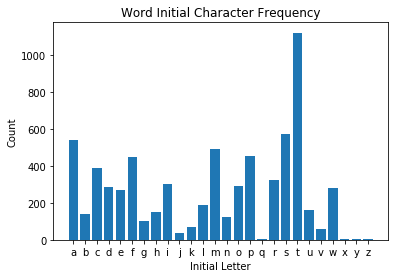

In [16]:

xlabels=[x[0] for x in firstLetterFrequency]
yvalues=[x[1] for x in firstLetterFrequency]
plt.bar(xlabels, yvalues)
plt.title("Word Initial Character Frequency")
plt.ylabel("Count")
plt.xlabel("Initial Letter")

# Something Different
* Example from the Apache Spark documentation
* Calculating Pi by the ratio of random points in the unit square at the origin that fall within the 1/4 unit circle (yellow) and outside of it (red) using 
\begin{equation*}
x^2+y^2<1
\end{equation*}
* Then multiply by 4 to get all 4 quadrants
<img src="http://www.oxfordmathcenter.com/images/notes/62-00.jpg" />

* First on a single cpu, then on all the cpus in our spark cluster and a job that is 12 times bigger to make it take long enough!


In [17]:
def lineartest():
    import random
    NUM_SAMPLES=100000000
    inside=0
    for i in range(0, NUM_SAMPLES):
        x=random.random()
        y=random.random()
        if (x*x) + (y*y) < 1:
            inside=inside+1
    print("Pi is roughly %f" % (4.0 * inside / NUM_SAMPLES))
%time lineartest()

Pi is roughly 3.141677
CPU times: user 49.4 s, sys: 5.03 ms, total: 49.5 s
Wall time: 49.6 s


In [18]:
def paralleltest():
    NUM_SAMPLES=100000000*12
    def inside(p):
        x, y = random.random(), random.random()
        return x*x + y*y < 1

    count = sc.parallelize(range(0, NUM_SAMPLES)) \
                 .filter(inside).count()
    print("Pi is roughly %f" % (4.0 * count / NUM_SAMPLES))
%time paralleltest()

Pi is roughly 3.141593
CPU times: user 13.6 ms, sys: 6 ms, total: 19.6 ms
Wall time: 50.9 s


# Spark Dataframes -- Think SQL
* Actually an implementation of HiveQL over tables of data
* Dataframes can be treated as SQL tables or as RDDs.

## Make Some Data

In [19]:
def generateRow(_=0):
    x=random.random()
    y=random.random()
    return (x,
            y,
            x*x + y*y < 1
           )
print("Example Output:")
generateRow()

Example Output:


(0.9164032197314876, 0.18204743177149274, True)

In [20]:
NUM_SAMPLES=100000000*12
# NUM_SAMPLES=20
generatedDataRDD = sc.parallelize(range(0, NUM_SAMPLES)).map(generateRow)

In [21]:
generatedDataDF = generatedDataRDD.toDF(schema=['X','Y','isInside'])
generatedDataDF.registerTempTable("points")

In [22]:
# This cell already done for you.  It writes the contents of generatedDataDF to disk 
# in an efficient format.  It will fail to run for you because your account will not have
# permission to write to /scratch/deschulz/.  Change the path to somewhere in your home
# directory if you want to try this.  It creates ~20GB of data so your quota needs to be
# large enough to handle all that data.

#!rm -rf /scratch/dschulz/randomdataDF.parquet
# generatedDataDF.take(10)
#generatedDataDF.write.parquet('/scratch/dschulz/randomdataDF.parquet')

In [23]:
!ls /scratch/dschulz/randomdataDF.parquet

_SUCCESS
part-00000-51891231-a5eb-4e64-8981-791c1612ecd0-c000.snappy.parquet
part-00001-51891231-a5eb-4e64-8981-791c1612ecd0-c000.snappy.parquet
part-00002-51891231-a5eb-4e64-8981-791c1612ecd0-c000.snappy.parquet
part-00003-51891231-a5eb-4e64-8981-791c1612ecd0-c000.snappy.parquet
part-00004-51891231-a5eb-4e64-8981-791c1612ecd0-c000.snappy.parquet
part-00005-51891231-a5eb-4e64-8981-791c1612ecd0-c000.snappy.parquet
part-00006-51891231-a5eb-4e64-8981-791c1612ecd0-c000.snappy.parquet
part-00007-51891231-a5eb-4e64-8981-791c1612ecd0-c000.snappy.parquet
part-00008-51891231-a5eb-4e64-8981-791c1612ecd0-c000.snappy.parquet
part-00009-51891231-a5eb-4e64-8981-791c1612ecd0-c000.snappy.parquet
part-00010-51891231-a5eb-4e64-8981-791c1612ecd0-c000.snappy.parquet
part-00011-51891231-a5eb-4e64-8981-791c1612ecd0-c000.snappy.parquet
part-00012-51891231-a5eb-4e64-8981-791c1612ecd0-c000.snappy.parquet
part-00013-51891231-a5eb-4e64-8981-791c1612ecd0-c000.snappy.parquet
part-00014-51891231-a5eb-4e64-8981-791c

In [24]:
!du -hs /scratch/dschulz/randomdataDF.parquet

19G	/scratch/dschulz/randomdataDF.parquet


## Load the Parquet data file


In [25]:
generatedDataDF=sqlCtx.read.parquet('/scratch/dschulz/randomdataDF.parquet')
sqlCtx.registerDataFrameAsTable(generatedDataDF, 'points')

# Run a SQL Query
* Against the table we just loaded
* We'll print the first few rows

In [26]:
%time sqlCtx.sql("SELECT * FROM points WHERE X > 0.5").take(10)

CPU times: user 1.35 ms, sys: 5.98 ms, total: 7.33 ms
Wall time: 4.41 s


[Row(X=0.7653002042914143, Y=0.42797580223527776, isInside=True),
 Row(X=0.5700557009860996, Y=0.900421513494445, isInside=False),
 Row(X=0.5288054565478099, Y=0.958931808257132, isInside=False),
 Row(X=0.7740213455219319, Y=0.47382977304623386, isInside=True),
 Row(X=0.5731820364443511, Y=0.3043384374719159, isInside=True),
 Row(X=0.6191027515107765, Y=0.38508545105889125, isInside=True),
 Row(X=0.7506836197637178, Y=0.22221542359621882, isInside=True),
 Row(X=0.6027432039612445, Y=0.32073048277957705, isInside=True),
 Row(X=0.956487328648317, Y=0.19926002266095444, isInside=True),
 Row(X=0.9293192958185261, Y=0.8875949800654069, isInside=False)]

In [27]:
%time result=sqlCtx.sql("SELECT count(*) as rowCount, isInside from points group by isInside").take(100)
result


CPU times: user 4.32 ms, sys: 1.01 ms, total: 5.33 ms
Wall time: 7.93 s


[Row(rowCount=942490407, isInside=True),
 Row(rowCount=257509593, isInside=False)]

In [28]:
InsideCount=result[0][0]
OutsideCount=result[1][0]
TotalCount=InsideCount+OutsideCount
print("Pi is roughly %f" % (4*InsideCount/TotalCount) )



Pi is roughly 3.141635


# Clean up

In [29]:
sc.stop()
sj.stop()

INFO:sparkhpc.sparkjob:


# Check job status

In [30]:
!squeue -u $USER


             JOBID       PARTITION     NAME            USER    STATE       TIME TIME_LIMIT  TIME_LEFT START_TIME NODES CPUS NODELIST(REASON)    
            879035          single jupyterh         dschulz  RUNNING       5:15    6:00:00    5:54:45 2019-05-27     1    1 cn002               
